## 1) script to scale all histograms in coffea files
- saved in outputs/scale/
- also scales the cutflow dictionary
## 2) adds the scaled files from multiple years.
- the histograms in the files must all have the same axes
## 3) makes root files for 2DAlphabet
- inclusive or split into regions
## 4) makes root files for combine
- for the previous analysis methods

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
hep.style.use("CMS")
from coffea import util
import itertools
import os, sys
import glob
import copy
import uproot
import time

sys.path.append('../python/')
import functions



In [32]:
data_events = {
    '2016': 6613811 + 120688407 + 124050331,
    '2016APV': 9726665 + 133752091 + 46495988 + 73330042 + 69219288 + 41564915,
    '2017': 96264601 + 46145204 + 89630771 + 115429972,
    '2018': 171484635 + 78255208 + 70027804 + 356976276,
    
          }

In [33]:
data_events

{'2016': 251352549, '2016APV': 374088989, '2017': 347470548, '2018': 676743923}

In [34]:
functions.makeSaveDirectories()

### analysis categories

In [35]:
label_map = functions.getLabelMap()
label_to_int = {label: i for i, label in label_map.items()}
signal_cats = [ i for label, i in label_to_int.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int.items() if 'at' in label]



print('------ analysis category map --------')
for i, lab in label_map.items():
    print(f'{i}: {lab}')
print('-------------------------------------')


print('\n\n------ coffea file content --------')

for hname in functions.loadCoffeaFile().keys():
    print(hname)
print('-------------------------------------')


------ analysis category map --------
0: at0bcen
1: at0bfwd
2: at1bcen
3: at1bfwd
4: at2bcen
5: at2bfwd
6: pret0bcen
7: pret0bfwd
8: pret1bcen
9: pret1bfwd
10: pret2bcen
11: pret2bfwd
12: 2t0bcen
13: 2t0bfwd
14: 2t1bcen
15: 2t1bfwd
16: 2t2bcen
17: 2t2bfwd
-------------------------------------


------ coffea file content --------
ttbarmass
numerator
denominator
jetmass
jetmsd
jetpt
jeteta
jetphi
jetp
mtt_vs_mt
deepak8_over_jetp
tau32_over_jetp
bdisc_over_jetpt
cutflow
weights
systematics
analysisCategories
-------------------------------------


## 1) Scale histograms in IOV

In [45]:
IOVs = [
#     '2016APV',
#     '2016',
#     '2017', 
    '2018'
]

for IOV in IOVs:
    
    coffeafiles = functions.getCoffeaFilenames()

    datasets = [
#         'QCD',
#         'TTbar', 
        'JetHT', 
#         'RSGluon', 
#         'ZPrime10', 
#         'ZPrime30', 
#         'ZPrimeDM'
    ]
    

    hasBkgEst = False
    blind = False #False if '2016' in IOV else True


    bkgest_str = '_bkgest' if hasBkgEst else ''
    filetype = 'weighted' if hasBkgEst else 'unweighted'

    lumifactor = 0.1 if blind else 1.0
    
    


    for ds in datasets:


        try:

            coffeafiles[ds][filetype][IOV].keys()
            sections = coffeafiles[ds][filetype][IOV].keys()

            files = []


            for s in sections:

                filename = coffeafiles[ds][filetype][IOV][s]
                
                print(filename)
                original_file = util.load(filename)

                file = copy.deepcopy(original_file)

                if 'JetHT' in ds:

                    files.append(file)

                else:

                    factor = 1.0 #functions.toptag_sf**2 if 'TTbar' in ds else 1.0
                    sf = functions.lumi[IOV] * lumifactor * functions.xs[ds][s] * factor / file['cutflow']['sumw']
                    sf_events = functions.lumi[IOV] * lumifactor * functions.xs[ds][s] / file['cutflow']['all events']
                    
                    for key in file.keys():

                        if 'hist' in str(type(file[key])):
                            file[key] = file[key] * sf

                        elif 'accumulator' in str(type(file[key])):
                            for cut in file[key].keys():
                                file[key][cut] = file[key][cut] * sf_events



                    files.append(file)

                    if 'RSGluon' in ds: 

                        util.save(file, f'../outputs/scale/{ds}{s}_{IOV}.coffea')
                        print(f'saving ../outputs/scale/{ds}{s}_{IOV}.coffea')

                    elif 'ZPrime' in ds:

                        util.save(file, f'../outputs/scale/ZPrime{s}_{ds.replace("ZPrime","")}_{IOV}.coffea')
                        print(f'saving ../outputs/scale/ZPrime{s}_{ds.replace("ZPrime","")}_{IOV}.coffea')


            if 'RSGluon' not in ds and 'ZPrime' not in ds:

                file = files[0]

                for f in files[1:]:
                    for key in file.keys():

                        if 'hist' in str(type(file[key])):
                            file[key] = file[key] + f[key]
                            
                            print(key, np.sum(file[key].values()), np.sum(f[key].values()) )

                        elif 'accumulator' in str(type(file[key])):
                            for cut in f[key].keys():
                                f[key][cut] = f[key][cut] + file[key][cut]

                savefilename = f'../outputs/scale/{ds}_{IOV}{bkgest_str}.coffea'
                util.save(file, savefilename)
                print(f'saving {savefilename}')

        except:

            filename = coffeafiles[ds][filetype][IOV]
            original_file = util.load(filename)
            file = copy.deepcopy(original_file)


            sf = functions.lumi[IOV] * lumifactor * functions.xs[ds] / file['cutflow']['sumw']
            sf_events = functions.lumi[IOV] * lumifactor * functions.xs[ds] / file['cutflow']['all events']


            for key in file.keys():
                

                if 'hist' in str(type(file[key])):
                    file[key] = file[key] * sf

                elif 'accumulator' in str(type(file[key])):

                    for cut in file[key].keys():

                        file[key][cut] = file[key][cut] * sf_events

            savefilename = f'../outputs/scale/{ds}_{IOV}{bkgest_str}.coffea'
            util.save(file, savefilename)
            print(f'saving {savefilename}')






/srv/outputs/JetHT_2018A.coffea
/srv/outputs/JetHT_2018B.coffea
/srv/outputs/JetHT_2018C.coffea
/srv/outputs/JetHT_2018D.coffea
ttbarmass 4607658.0 1508384.0
numerator 0.0 0.0
denominator 0.0 0.0
jetmass 4607980.0 1508440.0
jetmsd 4607910.0 1508402.0
jetpt 4608026.0 1508536.0
jeteta 4607174.0 1508148.0
jetphi 4608812.0 1508760.0
jetp 0.0 0.0
mtt_vs_mt 4606380.0 1507918.0
deepak8_over_jetp 0.0 0.0
tau32_over_jetp 0.0 0.0
bdisc_over_jetpt 0.0 0.0
ttbarmass 6159240.0 1551582.0
numerator 0.0 0.0
denominator 0.0 0.0
jetmass 6159594.0 1551614.0
jetmsd 6159508.0 1551598.0
jetpt 6159744.0 1551718.0
jeteta 6158474.0 1551300.0
jetphi 6160708.0 1551896.0
jetp 0.0 0.0
mtt_vs_mt 6157542.0 1551162.0
deepak8_over_jetp 0.0 0.0
tau32_over_jetp 0.0 0.0
bdisc_over_jetpt 0.0 0.0
ttbarmass 13320176.0 7160936.0
numerator 0.0 0.0
denominator 0.0 0.0
jetmass 13321024.0 7161430.0
jetmsd 13320858.0 7161350.0
jetpt 13321566.0 7161822.0
jeteta 13318274.0 7159800.0
jetphi 13323452.0 7162744.0
jetp 0.0 0.0
mtt_vs_m

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f6af1ffcdf0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

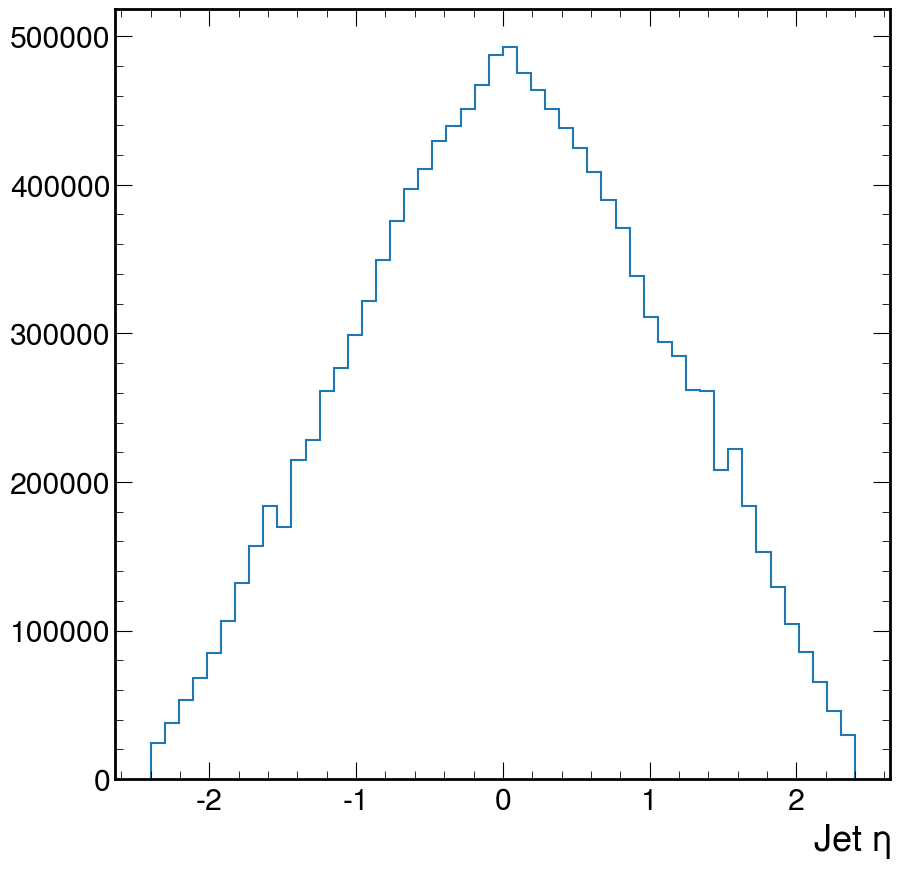

In [49]:
util.load('../outputs/scale/JetHT_2018.coffea')['jeteta'][{'anacat':sum, 'systematic':'nominal'}].plot()

## 2.1) Combine JetHT files (blinded)


In [ ]:
IOVs = ['2016APV', '2016']#, '2017', '2018']


hasBkgEst = True
bkgest_str = '_bkgest' if hasBkgEst else ''

files = []
for IOV in IOVs:

    file = util.load(f'../outputs/scale/JetHT_{IOV}{bkgest_str}.coffea')
    files.append(file)
    
systs = ['nominal', 'pileupDown', 'pileupUp', 'prefiringDown', 'prefiringUp', 'pdfDown', 'pdfUp', 'btagDown', 'btagUp', 'jesDown', 'jesUp', 'jerDown', 'jerUp']
file = files[0]
for f in files[1:]:
    for key in file.keys():

        if 'hist' in str(type(file[key])):
            
            file[key] = file[key] + f[key]            

        elif 'cutflow' in key:
            for cut in f[key].keys():
                f[key][cut] = f[key][cut] + file[key][cut]  


# savefilename = f'../outputs/scale/JetHT_blinded.coffea'

if hasBkgEst:
    savefilename = f'../outputs/scale/NTMJ_2016all_unblinded.coffea'
    
else:
    savefilename = f'../outputs/scale/JetHT_2016all_unblinded.coffea'


util.save(file, savefilename)
print(f'saving {savefilename}')


## 2.2) Combine MC files (for plotting)


In [ ]:
IOVs = [
    '2016APV',
    '2016',
    '2017', 
    '2018'
]

for IOV in IOVs:
    
    coffeafiles = functions.getCoffeaFilenames()

    datasets = [
        'QCD',
        'TTbar', 
        'JetHT', 
    ]

# all all RSGluon samples
datasets += ['RSGluon'+str(int(b)) for b in np.linspace(1000,5000,9)]
datasets += ['ZPrime'+str(int(b))+'_DM' for b in np.linspace(1000,5000,9)]
datasets += ['ZPrime'+str(int(b))+'_10' for b in np.linspace(1000,4000,4)]
datasets += ['ZPrime'+str(int(b))+'_30' for b in np.linspace(1000,4000,4)]



files = []

for ds in datasets:

    for IOV in IOVs:

        file = util.load(f'../outputs/scale/{ds}_{IOV}.coffea')
        files.append(file)


    file = files[0]
    for f in files[1:]:
        for key in file.keys():

            if 'hist' in str(type(file[key])):
                file[key] = file[key] + f[key]

            elif 'cutflow' in key:
                for cut in f[key].keys():
                    f[key][cut] = f[key][cut] + file[key][cut]  


    savefilename = f'../outputs/scale/{ds}_all.coffea'
    util.save(file, savefilename)
    print(f'saving {savefilename}')


## 2.3) Combine 2016noAPV and 2016APV

In [20]:


IOVs = ['2016', '2016APV']
datasets = ['TTbar', 'QCD', 'JetHT']


hasBkgEst = False
bkgest_str = '_bkgest' if hasBkgEst else ''


# add all signal samples
datasets += ['RSGluon'+str(int(b)) for b in np.linspace(1000,5000,9)]
datasets += ['ZPrime1000_10', 'ZPrime2000_10', 'ZPrime3000_10', 'ZPrime4000_10']
datasets += ['ZPrime1000_30', 'ZPrime2000_30', 'ZPrime3000_30', 'ZPrime4000_30']
datasets += ['ZPrime'+str(int(b))+'_DM' for b in np.linspace(1000,5000,9)]


for ds in datasets:
    
    files = []
    for IOV in IOVs:

        file = util.load(f'../outputs/scale/{ds}_{IOV}{bkgest_str}.coffea')
        files.append(file)


    file = files[0]
    for f in files[1:]:
        for key in file.keys():

            if 'hist' in str(type(file[key])):

                file[key] = file[key] + f[key]

            elif 'cutflow' in key:
                for cut in f[key].keys():
                    f[key][cut] = f[key][cut] + file[key][cut]  

    savefilename = f'../outputs/scale/{ds}_2016all{bkgest_str}.coffea'
    util.save(file, savefilename)
    print(f'saving {savefilename}')
    


saving ../outputs/scale/TTbar_2016all.coffea
saving ../outputs/scale/QCD_2016all.coffea
saving ../outputs/scale/JetHT_2016all.coffea
saving ../outputs/scale/RSGluon1000_2016all.coffea
saving ../outputs/scale/RSGluon1500_2016all.coffea
saving ../outputs/scale/RSGluon2000_2016all.coffea
saving ../outputs/scale/RSGluon2500_2016all.coffea
saving ../outputs/scale/RSGluon3000_2016all.coffea
saving ../outputs/scale/RSGluon3500_2016all.coffea
saving ../outputs/scale/RSGluon4000_2016all.coffea
saving ../outputs/scale/RSGluon4500_2016all.coffea
saving ../outputs/scale/RSGluon5000_2016all.coffea
saving ../outputs/scale/ZPrime1000_10_2016all.coffea
saving ../outputs/scale/ZPrime2000_10_2016all.coffea
saving ../outputs/scale/ZPrime3000_10_2016all.coffea
saving ../outputs/scale/ZPrime4000_10_2016all.coffea
saving ../outputs/scale/ZPrime1000_30_2016all.coffea
saving ../outputs/scale/ZPrime2000_30_2016all.coffea
saving ../outputs/scale/ZPrime3000_30_2016all.coffea
saving ../outputs/scale/ZPrime4000_30

## 2.4) Scale JetHT files if running over subset of data

In [ ]:
IOVs = [
#     '2016APV',
#     '2016',
#     '2017', 
    '2018'
]

for IOV in IOVs:
    
    coffeafiles = functions.getCoffeaFilenames()

    datasets = [ 'JetHT' ]
    

    hasBkgEst = False
    blind = False #False if '2016' in IOV else True


    bkgest_str = '_bkgest' if hasBkgEst else ''
    filetype = 'weighted' if hasBkgEst else 'unweighted'

    lumifactor = 0.1 if blind else 1.0


    for ds in datasets:

        sections = coffeafiles[ds][filetype][IOV].keys()

        files = []


        for s in sections:

            filename = coffeafiles[ds][filetype][IOV][s]
            original_file = util.load(filename)

            file = copy.deepcopy(original_file)

            sf = data_events[IOV] / file['cutflow']['all events']

            for key in file.keys():

                if 'hist' in str(type(file[key])):
                    file[key] = file[key] * sf

                elif 'cutflow' in key:
                    for cut in file[key].keys():
                        file[key][cut] = file[key][cut] * sf



                files.append(file)


        file = files[0]

        for f in files[1:]:
            for key in file.keys():

                if 'hist' in str(type(file[key])):
                    file[key] = file[key] + f[key]

                elif 'cutflow' in key:
                    for cut in f[key].keys():
                        f[key][cut] = f[key][cut] + file[key][cut]

        savefilename = f'../outputs/scale/{ds}_{IOV}{bkgest_str}.coffea'
        util.save(file, savefilename)
        print(f'saving {savefilename}')

## 3) Make root files for 2DAlphabet

In [ ]:
year = '2016all'
systematics = ['nominal', 'jes', 'jer', 'pileup', 'pdf', 'q2', 'btag', 'prefiring']
if '2018' in year: systematics[-1] = 'hem'
    
systematics

In [ ]:
toc = time.time()

year = '2017'



systematics = ['nominal', 'jes', 'jer', 'pileup', 'pdf', 'q2', 'btag', 'prefiring']
syst_labels = ['nominal']
if '2018' in year: 
    systematics = ['nominal', 'jes', 'jer', 'pileup', 'pdf', 'q2', 'btag']

for s in systematics:
    if not 'nominal' in s and not 'hem' in s:
        syst_labels.append(s+'Down')
        syst_labels.append(s+'Up')
        
print(syst_labels)


dataOnly = False
inclusive = False

if inclusive:
    
    cats, cat_labels = [''], ['']
    
else:

    cats = ['', '0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
    cat_labels = ['', 'cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']


# signals = ['RSGluon2000']
signals = ['RSGluon'+str(int(b)) for b in np.linspace(1000,5000,9)]
signals += ['ZPrime1000_10', 'ZPrime2000_10', 'ZPrime3000_10', 'ZPrime4000_10']
signals += ['ZPrime1000_30', 'ZPrime2000_30', 'ZPrime3000_30', 'ZPrime4000_30']
signals += ['ZPrime'+str(int(b))+'_DM' for b in np.linspace(1000,5000,9)]


savefileheader = '../outputs/combine/categories/TTbarAllHad{}_'.format(year.replace('20', '').replace('all',''))
                                                                
fdata  = uproot.recreate(savefileheader+'Data.root')

if not dataOnly:
    
    fttbar = uproot.recreate(savefileheader+'TTbar.root')
    sigfiles = [uproot.recreate(savefileheader+'signal'+sig+'.root') for sig in signals ]

for cat, catname in zip(cats, cat_labels):
    
    if cat == '':
        
        signal_cats = [ i for label, i in label_to_int.items() if '2t' in label]
        antitag_cats = [ i for label, i in label_to_int.items() if 'at' in label]
        sum_axes = ['anacat']

    else :
        
        signal_cats = label_to_int['2t'+cat]
        antitag_cats = label_to_int['at'+cat]
        sum_axes = []
    
    for syst in syst_labels:
        print(syst, cat)

        integrate_pass = {'anacat':signal_cats, 'systematic': syst}
#         integrate_fail = {'anacat':antitag_cats, 'systematic': syst}

        systname = syst.upper()[:-2] + 'up' if 'Up' in syst else syst.upper()[:-4] + 'down'

        if 'nominal' in syst:

            systname = ''
            hdata_pass = functions.getHist2('ttbarmass', 'JetHT', year, sum_axes=sum_axes, integrate_axes=integrate_pass) 
#             hdata_fail = functions.getHist2('mtt_vs_mt', 'JetHT', year, sum_axes=sum_axes, integrate_axes=integrate_fail) 

            fdata["data_obs_"+catname+systname] = hdata_pass
#             fdata["MttvsMt"+catname+"Fail"+systname] = hdata_fail

        if not dataOnly:
            
            sig_pass = [functions.getHist2('ttbarmass', sig, year, sum_axes=sum_axes, integrate_axes=integrate_pass) for sig in signals]
#             sig_fail = [functions.getHist2('mtt_vs_mt', sig, year, sum_axes=sum_axes, integrate_axes=integrate_fail) for sig in signals]

            httbar_pass = functions.getHist2('ttbarmass', 'TTbar', year, sum_axes=sum_axes, integrate_axes=integrate_pass) 
#             httbar_fail = functions.getHist2('mtt_vs_mt', 'TTbar', year, sum_axes=sum_axes, integrate_axes=integrate_fail) 


            # save hists

            fttbar["ttbar_"+catname+systname] = httbar_pass
#             fttbar["MttvsMt"+catname+"Fail"+systname] = httbar_fail
            
            
            for i, file in enumerate(sigfiles):
#                 print('signal'+str(i)+'_'+catname+systname)
                file['ttbarmass_'+catname+systname] = sig_pass[i]
#                 file["MttvsMt"+catname+"Fail"+systname] = sig_fail[i]


fdata.close()
                                                                
print('saving '+savefileheader+'Data_unblinded.root')

if not dataOnly:
    
    fttbar.close()
    for file in sigfiles:
        
        file.close()
        

    
    print('saving '+savefileheader+'TTbar.root')
    
    for sig in signals:
        print('saving '+savefileheader+sig+'.root')

        
        
tic = time.time()
print()
functions.printTime(tic-toc)


## 4) Make root files for combine

In [ ]:
year = '2016all'

dataOnly = False
inclusive = False

if inclusive:
    
    cats, cat_labels = [''], ['']
    
else:

    cats = ['0bcen', '0bfwd', '1bcen', '1bfwd', '2bcen', '2bfwd']
    cat_labels = ['cen0b', 'fwd0b', 'cen1b', 'fwd1b', 'cen2b', 'fwd2b']


signals = []
signals = ['RSGluon'+str(int(b)) for b in np.linspace(1000,5000,9)]
signals += ['ZPrime1000_10', 'ZPrime2000_10', 'ZPrime3000_10', 'ZPrime4000_10']
signals += ['ZPrime1000_30', 'ZPrime2000_30', 'ZPrime3000_30', 'ZPrime4000_30']
signals += ['ZPrime'+str(int(b))+'_DM' for b in np.linspace(1000,5000,9)]


savefileheader = '../outputs/combine/categories/TTbarAllHad{}_'.format(year.replace('20', '').replace('all',''))
                                                                
fdata  = uproot.recreate(savefileheader+'Data.root')

if not dataOnly:
    fttbar = uproot.recreate(savefileheader+'TTbar.root')
    
    sigfiles = [uproot.recreate(savefileheader+'signal'+sig+'.root') for sig in signals ]

for cat, catname in zip(cats, cat_labels):
    
    if inclusive:
        
        signal_cats = [ i for label, i in label_to_int.items() if '2t' in label]
        antitag_cats = [ i for label, i in label_to_int.items() if 'at' in label]
        sum_axes = ['anacat']

    else :
        
        signal_cats = label_to_int['2t'+cat]
        antitag_cats = label_to_int['at'+cat]
        sum_axes = []
    
    for syst in syst_labels:
        print(syst, cat)

        integrate_pass = {'anacat':signal_cats, 'systematic': syst}
#         integrate_fail = {'anacat':antitag_cats, 'systematic': syst}

        systname = syst.upper()[:-2] + 'up' if 'Up' in syst else syst.upper()[:-4] + 'down'

        if 'nominal' in syst:

            systname = ''
            hdata_pass = functions.getHist2('ttbarmass', 'JetHT', year, sum_axes=sum_axes, integrate_axes=integrate_pass) 
#             hdata_fail = functions.getHist2('mtt_vs_mt', 'JetHT', year, sum_axes=sum_axes, integrate_axes=integrate_fail) 

            fdata["data_obs_"+catname+systname] = hdata_pass
#             fdata["MttvsMt"+catname+"Fail"+systname] = hdata_fail

        if not dataOnly:
            
            sig_pass = [functions.getHist2('ttbarmass', sig, year, sum_axes=sum_axes, integrate_axes=integrate_pass) for sig in signals]
#             sig_fail = [functions.getHist2('mtt_vs_mt', sig, year, sum_axes=sum_axes, integrate_axes=integrate_fail) for sig in signals]

            httbar_pass = functions.getHist2('ttbarmass', 'TTbar', year, sum_axes=sum_axes, integrate_axes=integrate_pass) 
#             httbar_fail = functions.getHist2('mtt_vs_mt', 'TTbar', year, sum_axes=sum_axes, integrate_axes=integrate_fail) 


            # save hists

            fttbar["ttbar_"+catname+systname] = httbar_pass
#             fttbar["MttvsMt"+catname+"Fail"+systname] = httbar_fail
            
            
            for i, file in enumerate(sigfiles):
#                 print('signal'+str(i)+'_'+catname+systname)
                file['ttbarmass_'+catname+systname] = sig_pass[i]
#                 file["MttvsMt"+catname+"Fail"+systname] = sig_fail[i]


fdata.close()
                                                                
print('saving '+savefileheader+'Data.root')

if not dataOnly:
    
    fttbar.close()
    for file in sigfiles:
        
        file.close()
        

    
    print('saving '+savefileheader+'TTbar.root')
    
    for sig in signals:
        print('saving '+savefileheader+sig+'.root')